In [1]:
import qulacs
from openfermion.transforms import get_fermion_operator, jordan_wigner
from openfermion.linalg import get_sparse_operator
from openfermion.chem import MolecularData, geometry_from_pubchem
from openfermionpyscf import run_pyscf
from openfermionpsi4 import run_psi4
from scipy.optimize import minimize
from pyscf import fci
import numpy as np
from scipy.linalg import expm
import random
import matplotlib.pyplot as plt

In [17]:
basis = "sto-3g"
multiplicity = 1
charge = 0
# geometry = [["C", [0,0,0]],["H", [0.5541, 0.7996, 0.4965]],["H", [0.6833, -0.8134, -0.2536]],["H", [-0.7782, -0.3735, 0.6692]],["H", [-0.4593, 0.3874, -0.9121]]]
# geometry = [["O", [0, 0, 0]],["H", [0.2774, 0.8929, 0.2544]], ["H", [0.6068, -0.2383, -0.7169]]]
geometry = [["H", [0,0,0]],["H", [0,0,0.977]]]
description  = "tmp"
molecule = MolecularData(geometry, basis, multiplicity, charge, description)
molecule = run_psi4(molecule,run_scf=1,run_fci=1)
n_qubit = molecule.n_qubits
n_electron = molecule.n_electrons
fermionic_hamiltonian = get_fermion_operator(molecule.get_molecular_hamiltonian())
jw_hamiltonian = jordan_wigner(fermionic_hamiltonian)
print(jw_hamiltonian)

from qulacs import Observable
from qulacs.observable import create_observable_from_openfermion_text
qulacs_hamiltonian = create_observable_from_openfermion_text(str(jw_hamiltonian))

(-0.31349601563320545+0j) [] +
(-0.04883472637266054+0j) [X0 X1 Y2 Y3] +
(0.04883472637266054+0j) [X0 Y1 Y2 X3] +
(0.04883472637266054+0j) [Y0 X1 X2 Y3] +
(-0.04883472637266054+0j) [Y0 Y1 X2 X3] +
(0.13978238289201536+0j) [Z0] +
(0.1576263054951328+0j) [Z0 Z1] +
(0.10745382588884603+0j) [Z0 Z2] +
(0.15628855226150656+0j) [Z0 Z3] +
(0.13978238289201536+0j) [Z1] +
(0.15628855226150656+0j) [Z1 Z2] +
(0.10745382588884603+0j) [Z1 Z3] +
(-0.13686895080362443+0j) [Z2] +
(0.16419290099118963+0j) [Z2 Z3] +
(-0.13686895080362443+0j) [Z3]


In [13]:
from qulacs import QuantumState, QuantumCircuit
from qulacs.gate import CNOT, RY, RZ, merge

depth = n_qubit
cn = [1] * n_qubit
r = 0
bn = [0] * n_qubit
gate_set = 4

In [14]:
from qulacs.gate import DenseMatrix
def create_hamiltonian_time_evolution_gate(n_qubit, cn, gamma, Bn, t):
    I_gate = [[1,0],[0,1]]
    X_gate = [[0,1],[1,0]]
    Y_gate = [[0,0-1j],[0+1j,0]]
    Z_gate = [[1,0],[0,-1]]
    
    XX= np.array(np.zeros(2**n_qubit))
    YY= np.array(np.zeros(2**n_qubit))
    Zn= np.array(np.zeros(2**n_qubit))
    for k in range(n_qubit-1):
        for l in range(n_qubit):
            if k==l:
                if l==0:
                    hamiX = X_gate
                    hamiY = Y_gate
                else:
                    hamiX = np.kron(hamiX,X_gate)
                    hamiY = np.kron(hamiY,Y_gate)

            elif k+1==l:
                hamiX = np.kron(hamiX,X_gate)
                hamiY = np.kron(hamiY,Y_gate)
            else:
                if l==0:
                    hamiX = I_gate
                    hamiY = I_gate
                else:
                    hamiX = np.kron(hamiX,I_gate)
                    hamiY = np.kron(hamiY,I_gate)
        XX = XX+ 0.5*cn[k]*(1+gamma)*hamiX
        YY = YY+ 0.5*cn[k]*(1-gamma)*hamiY
        
    for m in range(n_qubit):
        for n in range(n_qubit):
            if m==n:
                if n==0:
                    hamiZ = Z_gate
                else:
                    hamiZ = np.kron(hamiZ,Z_gate)
            
            else:
                if n==0:
                    hamiZ = I_gate
                else:
                    hamiZ = np.kron(hamiZ,I_gate)
        
        Zn = Zn + Bn[m]*hamiZ

    hamiltonian = XX + YY + Zn
    hami_gate = expm(-1j*hamiltonian*t)
    
    return DenseMatrix(list(range(n_qubit)), hami_gate)

In [5]:
def he_ansatz_circuit(n_qubit, depth, theta_list):
    """he_ansatz_circuit
    Returns hardware efficient ansatz circuit.

    Args:
        n_qubit (:class:`int`):
            the number of qubit used (equivalent to the number of fermionic modes)
        depth (:class:`int`):
            depth of the circuit.
        theta_list (:class:`numpy.ndarray`):
            rotation angles.
    Returns:
        :class:`qulacs.QuantumCircuit`
    """
    circuit = QuantumCircuit(n_qubit)
    for d in range(depth):
        circuit.add_gate(CNOT(0, 1))
        circuit.add_gate(merge(RY(0, theta_list[gate_set*d+1]), RZ(0, theta_list[gate_set*d+2])))
        circuit.add_gate(merge(RY(1, theta_list[gate_set*d+3]), RZ(1, theta_list[gate_set*d+4])))
        circuit.add_gate(create_hamiltonian_time_evolution_gate(n_qubit, cn, r, bn, theta_list[0]))

    return circuit

In [6]:
def cost(theta_list):
    state = QuantumState(n_qubit) #|00000> を準備
    circuit = he_ansatz_circuit(n_qubit, depth, theta_list) #量子回路を構成
    circuit.update_quantum_state(state) #量子回路を状態に作用
    return qulacs_hamiltonian.get_expectation_value(state) #ハミルトニアンの期待値を計算

In [15]:
cost_history = []
t = np.array([random.uniform(0.0,10.0)])
init_random_list = np.append(t, np.random.random(2*n_qubit*(depth+1))*1e-1)
cost_history.append(cost(init_random_list))
method = "BFGS"
options = {"disp": True, "maxiter": 50, "gtol": 1e-6}
opt = minimize(cost, init_random_list,
               method=method,
               callback=lambda x: cost_history.append(cost(x)))
print(cost_history)

KeyboardInterrupt: 

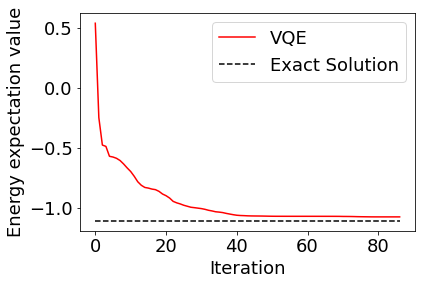

In [8]:
plt.rcParams["font.size"] = 18
plt.plot(cost_history, color="red", label="VQE")
plt.plot(range(len(cost_history)), [molecule.fci_energy]*len(cost_history), linestyle="dashed", color="black", label="Exact Solution")
plt.xlabel("Iteration")
plt.ylabel("Energy expectation value")
plt.legend()
plt.show()

In [9]:
geometry = geometry_from_pubchem('oxidane')
print(geometry)

[('O', (0, 0, 0)), ('H', (0.2774, 0.8929, 0.2544)), ('H', (0.6068, -0.2383, -0.7169))]
